<a href="https://colab.research.google.com/github/Eminent01/AMMI-RL/blob/main/%5BAMMI_2022%5D_Introduction_to_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Licence


In [ ]:
#Licence
#Copyright 2021 Google LLC.
#SPDX-License-Identifier: Apache-2.0

#JAX Tutorial
This first practical aims at getting familliar with some of the tools we will be using in the next practicals.

##Installation

In [2]:
#@title Installations  { form-width: "30%" }

!pip install dm-acme
!pip install dm-acme[reverb]
!pip install dm-acme[jax]
!pip install dm-acme[tf]
!pip install dm-acme[envs]
!pip install dm-env
!pip install dm-haiku
!pip install chex
!pip install imageio
!pip install gym

from IPython.display import clear_output
clear_output()

In [3]:
#@title Imports  { form-width: "30%" }

from typing import *
import IPython

import base64
import chex
import collections
from collections import namedtuple
import dm_env
import enum
import functools
import gym
import haiku as hk
import io
import itertools
import jax
from jax import tree_util
import optax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import reverb
import rlax
import time
from bsuite import environments
import bsuite.environments.catch as dm_catch

import warnings

np.set_printoptions(precision=3, suppress=1)

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


# Introduction to JAX

To implement our RL algorithms, we will resort to neural networks as our function approximators, and we will train them using gradient based optimizers. To make that easy, we will use <a href="https://github.com/google/jax">JAX</a>, to get access to easy gradient computations with a numpy-like flavor, and <a href="https://github.com/deepmind/dm-haiku">Haiku</a>, to easily define our neural network architectures. If you are familiar with other frameworks, JAX/Haiku respectively corresponds to tensorflow/keras pytorch/pytorch.nn.

If you need further tutorial, go to: https://jax.readthedocs.io/en/latest/jax-101/index.html

### 1. JAX Basics

JAX is a numerical computation library, very close to numpy for its basic use, that allows one to easily execute operations on GPU, and gives access to <a href="https://github.com/google/jax#transformations">numerical function transformations</a>, that allows for gradient computations, automatic vectorization, or jitting.

JAX has a _functional_ flavor; to be able to use numerical function transformations, you will have to define _pure_ functions, i.e. mathematical functions, whose result do not depend on the context in which they are used.

For instance the following function is pure:

In [4]:
def pure_function(x: chex.Array) -> chex.Array:
  return 3 * x + jnp.tanh(2 * x) / (x ** 2 + 1)

The following method is not pure:

In [5]:
class Counter:
  def __init__(self) -> None:
    self._i = 0.

  def unpure_function(self, x: chex.Array) -> chex.Array:
    self._i = self._i + 1.
    return self._i * x + jnp.tanh(x)

Given a pure function, you can easily obtain the associated gradient function:

In [6]:
grad_pure = jax.grad(pure_function)
x = 3.
print(f'Value at point x={x}, f(x)={pure_function(x)}, grad_f(x)={grad_pure(x)}')

Value at point x=3.0, f(x)=9.099998474121094, grad_f(x)=2.9400057792663574


In addition to `jax.grad`, JAX provides `jax.vmap` for automatic vectorization, `jax.jit` for jitting (to fully make use of specialized hardware) and `jax.pmap`, to automatically distribute functions accross devices.

For instance, if you want to have a batched version of matrix multiplication, you can use the usual matrix multiplication, and directly vmap it in the following way:

In [7]:
batch_matrix_multiply = jax.vmap(lambda a, b: a @ b)
rng = jax.random.PRNGKey(0)
rng_a, rng_b = jax.random.split(rng)
a = jax.random.normal(key=rng_a, shape=(12, 5, 7))
b = jax.random.normal(key=rng_b, shape=(12, 7, 9))
print(batch_matrix_multiply(a, b).shape)

(12, 5, 9)


In [8]:
d= jax.random.normal(rng, (3,3))
d

DeviceArray([[-0.372,  0.264, -0.183],
             [-0.737,  0.45 , -0.152],
             [-0.671, -0.591,  0.732]], dtype=float32)

In this example, we have been hitting one of the differences between JAX numpy and numpy. Numpy handles random seeds _implicitly_, when you want a random
number, you get one by simply calling one of numpy's functions, and the number
will depend on numpy global seed. With JAX, random seeds are handled _explicitly_, and each function that needs to generate random numbers takes a random key as additional input. This has to do with the functional paradigm of JAX: if we were not handling the random key explicitly, each call to a random function would lead to a different result, breaking the pure function hypothesis. By passing the random key explicitly, we make sure that the same random function, called with the same random key, will produce the same result. As a side effect, this also make results produced using JAX easily reproducible, as it is easy to trace which random seeds have been used where. To
know more about how JAX handles randomness, you can read <a href="https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#rngs-and-state">this page<a>.

### ***Exercises***

As a first exercise, we are giving you the following function

In [9]:
def func(x: chex.Array) -> chex.Array:
  return x ** 2

(array([11.,  6.,  9., 10., 10., 11., 12.,  8., 14.,  9.]),
 array([0.024, 0.121, 0.217, 0.314, 0.411, 0.507, 0.604, 0.701, 0.798,
        0.894, 0.991], dtype=float32),
 <a list of 10 Patch objects>)

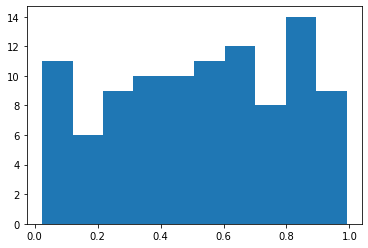

In [10]:
x = jax.random.uniform(rng, (100,))
plt.hist(x)

which simply computes the square of an array. By using simple jax transformations can you get a function that takes a batch of scalars, and outputs the value of the gradient of the squared function for each element of the batch?

**Hint:** jax.grad can only take as input a function that outputs a single scalar, so calling jax.grad directly on func and applying it to a vector won't work.

Can you make this function run faster?

In [13]:
grad = jax.vmap(jax.grad(func))
grad(x)

DeviceArray([0.048, 1.705, 1.626, 1.028, 0.343, 1.605, 1.025, 0.697,
             1.011, 0.674, 0.217, 0.21 , 1.677, 1.58 , 0.681, 1.67 ,
             0.492, 0.428, 0.048, 1.123, 0.561, 1.887, 1.224, 1.477,
             1.048, 1.309, 0.82 , 0.481, 1.489, 0.071, 1.702, 0.049,
             0.945, 1.454, 0.701, 1.255, 1.222, 0.131, 1.618, 0.426,
             1.293, 0.649, 1.108, 1.77 , 1.918, 1.677, 0.978, 0.236,
             0.339, 1.673, 1.175, 1.373, 1.91 , 1.16 , 0.56 , 0.695,
             1.04 , 1.962, 1.129, 0.489, 1.374, 1.923, 0.96 , 1.779,
             1.417, 1.897, 1.355, 0.883, 0.736, 1.903, 0.618, 1.418,
             1.75 , 1.219, 1.215, 0.453, 1.073, 1.924, 0.163, 1.053,
             1.718, 1.297, 0.932, 0.632, 0.87 , 0.967, 0.826, 1.47 ,
             0.305, 1.341, 0.169, 0.091, 0.422, 0.931, 1.473, 0.465,
             0.442, 1.982, 1.757, 0.821], dtype=float32)

In [14]:
#@title **[Implement]** Batched gradients { form-width: "30%" }
batched_grad = jax.vmap(jax.grad(func))
fast_batched_grad = jax.jit(batched_grad)

You can test your solution by running the cell below

In [15]:
#@title **[Test]** Batched gradients (Uncomment to run){ form-width: "30%" }
key = jax.random.PRNGKey(0)
normal = jax.random.normal(key=key, shape=(3,))
if (fast_batched_grad(normal) == 2 * normal).all():
  print('Probably correct.')
else:
  print('Provably incorrect.')

Probably correct.


Can you do the same for a batch of batches, without flattening your input? (i.e. you have a matrix of numbers, and you want a matrix containing the gradient for each of the numbers in the matrix.)

In [16]:
#@title **[Implement]** Matrix gradients { form-width: "30%" }
fast_matrix_grad = jax.jit(jax.vmap(batched_grad))

In [17]:
#@title **[Test]** Matrix gradients (Uncomment to run){ form-width: "30%" }
key = jax.random.PRNGKey(0)
normal = jax.random.normal(key=key, shape=(3, 3,))
if (fast_matrix_grad(normal) == 2 * normal).all():
  print('Probably correct.')
else:
  print('Probably incorrect.')

Probably correct.


Another very useful application of `vmap` is batched indexing. Assume you have a `[B1, B2, ..., BN]` tensor of indices `idx`, and a `[B1, B2, ..., BN, F]` tensor of features `features`, and for each element `i1, ..., iN`, you
would like to  retrieve element `features[i1, ..., iN, idx[i1, ..., iN]]` from
the feature tensor, can you do this easily using vmap? (maybe start with a fixed `N`, then generalize to all `N`'s.)

In [ ]:
#@title **[Implement]** Batched indexing { form-width: "30%" }
def batched_indexing(idxs: chex.Array, features: chex.Array) -> chex.Array:
  ##### IMPLEMENT #####
  def simple_indexing(idx: chex.Array, feature: chex.Array) -> chex.Array:
    return feature[idx]
  N = idxs.ndim
  bidx = simple_indexing
  for _ in range(N):
    bidx = jax.vmap(bidx) 
  return jax. jit(bidx(idxs, features))def simple_indecing()
  pass

In [22]:
d =jnp.arange(1,10)
index =[1,2,3]
d
d.at[index]

_IndexUpdateRef(DeviceArray([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), [1, 2, 3])

In [ ]:
# def func(idx, feat):
#   return feat[idx]

# jax.vmap(func)(idx, feat)

In [ ]:
#@title **[Test]** Batched indexing (Uncomment to run){ form-width: "30%" }
inputs = jnp.array([[-0.196,  0.255,  0.573,  0.441, -0.847,  0.318,  0.646],
 [ 0.034, -0.889, -0.266, -1.561, -0.638, -0.442,  0.91 ],
 [-0.017,  0.758,  1.089,  0.299,  1.491,  0.079, -1.222],
 [ 0.952,  0.21,   1.386, -0.338,  2.952, -0.995, -0.516],
 [ 0.292, -0.143,  1.614,  1.643,  0.114,  0.254, -1.306],])
outputs = jnp.array([ 0.255, -1.561,  0.079,  1.386, -1.306])
idxs = jnp.array([1, 3, 5, 2, 6], dtype=jnp.int32)
if (batched_indexing(idxs, inputs) == outputs).all():
  print('Probably correct.')
else:
  print('Probably incorrect.')

### 2. Let's talk about gradients

Gradients manipulation are the core of deep learning and therefore in this class, you will have to use them quite a lot.

In the previous section, you used the function [`jax.grad`](https://jax.readthedocs.io/en/latest/_autosummary/jax.grad.html) which allows you to evaluate the gradient of a function. The default behavior of `jax.grad` is to diffferentiate only with respect to the first argument. For example, have a look at the following: 

In [23]:
def my_func(x: chex.Array, y: chex.Array) -> chex.Array:
  return (x + y*y).sum()

grad_my_func = jax.grad(my_func)

# The gradient of this function with respect to x is a vector with the same
# shape as x but filled with ones.

test_x = jnp.asarray([1., 1.])
test_y = jnp.asarray([2., 2.])
print(grad_my_func(test_x, test_y))
print(grad_my_func(test_x, 2*test_y))

[1. 1.]
[1. 1.]


However in deep learning, we rarely want to compute the gradient of a single vector. Fortunately, jax gives us several ways to do that.

For example, by using argument `argnums` we can tell jax to compute the gradient with respect to the argument at the given position. Let try it with our function:

In [24]:
def my_func(x: chex.Array, y: chex.Array) -> chex.Array:
  return (x + y*y).sum()

# Now we are computing the gradient with respect to the second argument y
grad_my_func = jax.grad(my_func, argnums=1)

# This gradient is equal to 2*y

test_x = jnp.asarray([1., 1.])
test_y = jnp.asarray([2., 2.])
print(grad_my_func(test_x, test_y))
print(grad_my_func(test_x, 2*test_y))

[4. 4.]
[8. 8.]


You can provide argnums with a list of integer instead of one value, in this case, the function will return a gradient for each index you gave:

In [25]:
def my_func(x: chex.Array, y: chex.Array) -> chex.Array:
  return (x + y*y).sum()

# Now we are computing the gradient with respect to both arguments
grad_my_func = jax.grad(my_func, argnums=(0, 1))

# This gradient is equal to (1, 2*y)

test_x = jnp.asarray([1., 1.])
test_y = jnp.asarray([2., 2.])

# Notice that the function now outputs two values
print(grad_my_func(test_x, test_y))
print(grad_my_func(test_x, 2*test_y))

(DeviceArray([1., 1.], dtype=float32), DeviceArray([4., 4.], dtype=float32))
(DeviceArray([1., 1.], dtype=float32), DeviceArray([8., 8.], dtype=float32))


***Exercise***

Let's consider a function $f$, which given a set of parameters $(a, b, \theta) \in \mathbb{R}^{NxNxM}$ computes the value:

$ f(a, b, \theta) = \sum_{i=1}^N a_ib_i + \sum_{j=1}^M \theta_j $

Code a function in jax which outputs the couple $(\nabla f_a, \nabla f_\theta)$.

In [29]:
# Your code here !
def gradient_func(test_a ,test_b, theta):
  f= jnp.sum(test_a * test_b) + jnp.sum(theta)
  return f
grad = jax.grad(gradient_func, argnums =(0,2))

## Test it with the following values
test_a = jnp.asarray([1., 1.])
test_b = jnp.asarray([2., 2.])
test_theta = jnp.asarray([2., 2., 2.])

In [30]:
grad(test_a,test_b,test_theta)

(DeviceArray([2., 2.], dtype=float32),
 DeviceArray([1., 1., 1.], dtype=float32))

This is better, but in deep learning we usually don't handle just a pair of vectors: we deal with hundreds of them (with their gradient) at the same time. So how are we going to pass all theses gradients around ? Well, it happens that jax also works with dictionary of parameters, or any nested structure containing dicts, tuples or lists. 

In [31]:
def my_fun_with_lots_of_params(params : Mapping[str, chex.Array]) -> float:
  x = params['x']
  y = params['y']
  z = params['y']
  return  (x**2 + 2*y + x*z).sum()

# Now let's compute the gradient
grad_my_func = jax.grad(my_fun_with_lots_of_params)

test_x = jnp.asarray([1., 1.])
test_y = jnp.asarray([2., 2.])
test_z = jnp.asarray([3., 3.])

params_dict = {'x' : test_x, 'y': test_y, 'z' : test_z}

# Now my gradient outputs a dictionary of values
print(grad_my_func(params_dict))

{'x': DeviceArray([4., 4.], dtype=float32), 'y': DeviceArray([3., 3.], dtype=float32), 'z': DeviceArray([0., 0.], dtype=float32)}


***Exercise***

Compute the gradients $(\nabla f_a, \nabla f_\theta)$ where $f$ is the function defined in the previous exercise but this time use a dictionary containing the parameters $(a, \theta)$.

In [36]:
### Your code here

## Test it with the following values
test_a = jnp.asarray([1., 1.])
test_b = jnp.asarray([2., 2.])
test_theta = jnp.asarray([2., 2., 2.])

In [37]:
def gradient_func(params : Mapping[str, chex.Array]) -> float:
  x = params['x']
  y = params['y']
  z = params['z']
  f= jnp.sum(x*y) + jnp.sum(z)
  return f
grad_my_func = jax.grad(gradient_func)

test_a = jnp.asarray([1., 1.])
test_b = jnp.asarray([2., 2.])
test_theta = jnp.asarray([2., 2., 2.])
params_dict = {'x' : test_a, 'y': test_b, 'z' : test_theta}

# Now my gradient outputs a dictionary of values
print(grad_my_func(params_dict))

{'x': DeviceArray([2., 2.], dtype=float32), 'y': DeviceArray([1., 1.], dtype=float32), 'z': DeviceArray([1., 1., 1.], dtype=float32)}


In [ ]:
# def my_func(params, b):
#    return (params['a']*b).sum() + params['theta'].sum()

# my_grad = jax.grad(my_func)
# test_a = jnp.asarray([1., 1.])
# test_b = jnp.asarray([2., 2.])
# test_theta = jnp.asarray([2., 2., 2.])

# print(my_grad(dict(a=test_a, theta = test_theta), b)

### 3. Diving a bit deeper in JAX internals


To get a better understanding of what you can and cannot do with JAX, we will dive a bit deeper into its internals.

When you define a function in term of JAX (or `jax.numpy`) operations, JAX allows you to produce a `jaxpr` for this function. A `jaxpr` is simply a reformulation of the function in JAX's own language. You can examine this `jaxpr` by applying the `jax.make_jaxpr`.

Internally, to get this `jaxpr`, JAX **traces** the function. Tracing the function means that, instead of passing in the actual inputs/tensors that you provided to the function, JAX will pass *abstract tensors*, that typically contain the shape and dtype information of your actual inputs, but not necessarily their values. By passing those abstract tensors through the sequence of operations that the function performs, and remembering the sequence of operations applied, JAX can build a computational graph, much like PyTorch would. After reaching the return statement of the function, JAX can transcribe this computational graph into a sequence of operations that will constitute the `jaxpr` for the function.

The code below provides an example of `jaxpr` produced by tracing two functions `func1` and `func2`. As you can see, JAX decomposes each expression into elementary operations, that makes it so that the `jaxpr` for the two functions are the same.

In [38]:
def func1(a: chex.Array, b: chex.Array):
  temp = a + jnp.sin(b) * 3.
  return jnp.sum(temp)


def func2(a: chex.Array, b: chex.Array):
  x = jnp.sin(b)
  x = x * 3
  y = a
  temp = x + y
  temp = jnp.sum(temp)
  return temp

  
print(jax.make_jaxpr(func1)(jnp.zeros(8), jnp.ones(8)))
print()
print(jax.make_jaxpr(func2)(jnp.zeros(8), jnp.ones(8)))

{ lambda ; a:f32[8] b:f32[8]. let
    c:f32[8] = sin b
    d:f32[8] = mul c 3.0
    e:f32[8] = add a d
    f:f32[] = reduce_sum[axes=(0,)] e
  in (f,) }

{ lambda ; a:f32[8] b:f32[8]. let
    c:f32[8] = sin b
    d:f32[8] = mul c 3.0
    e:f32[8] = add d a
    f:f32[] = reduce_sum[axes=(0,)] e
  in (f,) }


Translating python into `jaxpr` is how JAX is able to compute *transformations* of the initial function provided, such as computing gradients with `jax.grad`, parallelizing with `jax.vmap`, or jitting, with `jax.jit`. For instance, when you apply `jax.grad` to a function and use the resulting function on an input, internally, `jax` traces through the original function, then, from the `jaxpr` of the forward pass produces the `jaxpr` corresponding to the backward pass (much like you would be able to backpropagate through a computational graph once you have built it). 

Using the `jax.make_jaxpr` function, you can have a look at the jaxpr produced when you are computing the gradient of a given function.

In [39]:
def func3(a: chex.Array):
  return jnp.sum(jnp.sin(a))

print(jax.make_jaxpr(func3)(jnp.ones(8)))
print()
print(jax.make_jaxpr(jax.grad(func3))(jnp.ones(8)))

{ lambda ; a:f32[8]. let
    b:f32[8] = sin a
    c:f32[] = reduce_sum[axes=(0,)] b
  in (c,) }

{ lambda ; a:f32[8]. let
    b:f32[8] = sin a
    c:f32[8] = cos a
    _:f32[] = reduce_sum[axes=(0,)] b
    d:f32[8] = broadcast_in_dim[broadcast_dimensions=() shape=(8,)] 1.0
    e:f32[8] = mul d c
  in (e,) }


When you simply call `jax.grad` or `jax.vmap` on a function, without jitting the result, JAX will build the forward and backpropagation `jaxpr` each time you are calling the gradient function. This has upsides, such as, for example, giving you the possibility to print debug, by printing the values and shapes of the traced tensors on each calls, giving you the possibility to set breakpoints within your function, or allowing you to change the shape and dtypes of your arguments on each call. However, this also bears a lot of additional costs, as you need to recompute the graph each time you are calling the function, and you are typically unable to optimize what happens internally in your function (e.g. reducing memory or computation usage by recognizing computations that produce the same quantities, or merging operations into primitives of the hardware that you are considering).

On the other hand, when you `jit` a function, JAX traces the function that you provided, produces a `jaxpr` for this function, and optimizes the resulting `jaxpr` based function. JAX will neither trace, nor recompile a jitted function when it is called several times on inputs with similar shapes and dtypes (but not necessarily values). It will simply reused the optimised version that was obtained after the first tracing and compilation. This typically explains why JAX is adverse to non pure functions: as tracing is done only once for a jitted function, the jitted function is blind to changes in the original python function that may have been occasionated by side effects in the program.

On a side note, tracing and compilation will be performed each time you provide an argument with a different `shape` or `dtype` to a jitted function. This happens notably because JAX (and its underlying backend XLA) checks shapes, and tries to optimize computations based on the shapes of the tensors provided as input.

#### 3.1. JAX and prints


One consequence of the fact that jitting makes it so that the initial function you defined is replaced by a `jaxpr` based equivalent is that when jitting a function, print statements or breakpoints will only appear at **trace** time (i.e. each time the jitted function is applied with an input with different shapes), since those print statements are not transcribed to `jaxpr`.

**Question:** Before executing the next cell, try to guess the result that you will be obtaining.

In [ ]:
def func5(x: chex.Array) -> chex.Array:
  print("Hey, I am called!!! X value is:", x)
  ln_x = jnp.log(x)
  ln_2 = jnp.log(2.0)
  return ln_x / ln_2

print("In the trace, there is no 'trace' of the print call")
print(jax.make_jaxpr(func5)(3.))
print()


# not jitted (the trace is regenerated at each time)
print("Function calls before jit")
func5(3.0)
func5(3.0)
func5(3.0)

# jitted (trace is generated once, and thus the python call is done only once)
print("Function calls after jit")
func5_jit = jax.jit(func5)
func5_jit(3.0)
func5_jit(3.0)
func5_jit(3.0)
print("Changing the shape of the argument")
func5_jit(jnp.array([3.0, 3.0]))
func5_jit(jnp.array([3.0, 3.0]))
print("Done!")

#### 3.2. JAX and control flows


One other consequence of JAX's tracing process is that, when you are jitting a function, JAX starts by tracing the function, i.e. executing the function with **Tracer values**, which can typically not be used as operands for python logical control flows. Typically, you cannot compare the value of a traced tensor to anything.

**Question:** 
Do you think that the following code works? Why?

In [ ]:
def func6(x: chex.Array):
  if x > 0:
    return x
  else:
    return 2 * x

print(func6(10))
print(func6(-10))

**Question:** 
Do you think that the following code works?

In [ ]:
def func6(x: chex.Array):
  if x > 0:
    return x
  else:
    return 2 * x

func6_jit = jax.jit(func6)
print(func6_jit(10))
print(func6_jit(-10))

#### Explanation



Passing in a Tracer value to the "if" does not evaluate to something sensical, you cannot pick between the branches, so jax is raising an error!

**Question:** Do you think the following code runs

In [ ]:
def func7(x: chex.Array, is_training: bool):
  if is_training:
    return x
  else:
    return 2 * x

func7_jit = jax.jit(func7)
print(func7_jit(10, is_training=True))
print(func7_jit(10, is_training=False))


#### 3.3. JAX and static arguments


One solution is to tell JAX not to trace the value of the second argument when jitting. There are essentially two ways of doing that. One is to explicitly ask JAX to not trace the second argument, by using the `static_argnums` argument of the jit function, and specifying the argument at position 1. The other one is to define two versions of the above function, one specialized for the value `is_training=True` and one specialized for the value `is_training=True`, typically by using `functools.partial`.

In [ ]:
import functools
func7_training_jit = jax.jit(functools.partial(func7, is_training=True))
func7_evaluation_jit = jax.jit(functools.partial(func7, is_training=False))

print(func7_training_jit(10))
print(func7_evaluation_jit(10))

You also have some control flow operations in JAX, when you really need to have tensor value dependent control flows, e.g. `jax.lax.cond`!


```
def cond(pred, true_fun, false_fun, *operands):
  if pred:
    return true_fun(*operands)
  else:
    return false_fun(*operands)
```
JAX built-in control flows are typically to be used when the control flows you want to implement are depending on things that need to be tensor values (e.g. parameters, gradients, value of activations, ...). For other control flows, you should rather use `static_argnums` or `functools.partial`.

In [ ]:
def func8(x: chex.Array, is_training: bool):
  # This would typically not be a great example, since is_training
  # can easily be made to be not a tensor value.
  return jax.lax.cond(is_training, 
                      lambda a: a,   # provide the function if true
                      lambda a: 2*a, # profide the function is false
                      operand=x)     # say which variable to use

func8_jit = jax.jit(func8)
print(func8_jit(10, is_training=True))
print(func8_jit(10, is_training=False))


### 4. Diving even deeper into JAX internals

To get a sense of what kind of optimizations `jax.jit` is doing, we would like to have a look at the code produced when using either a plain old 'inefficient' function, and its jitted version. For the sake of the example, let's look at the following naive function: 

In [ ]:
def f(x: chex.Array) -> chex.Array:
  x1 = x + 3.
  x2 = x + 3.
  return x1 + x2

We can rewrite a simpler more efficient version quite easily as:

In [ ]:
def g(x: chex.Array) -> chex.Array:
  x1 = x + 3.
  return x1 + x1

Let us first have a look at the `jaxpr` produced when we use `jax.make_jaxpr` on both functions:

In [ ]:
print(f"f's jaxpr: \n {jax.make_jaxpr(f)(1.)}")
print(f"g's jaxpr: \n {jax.make_jaxpr(g)(1.)}")

We notice that, even when tracing to produce the `jaxpr`, JAX does not optimize the computation by merging the computations of `x1` and `x2`. Let's have a look at what happens when we are using `jax.jit`:

In [ ]:
print(f"jitted f's jaxpr: \n {jax.make_jaxpr(jax.jit(f))(1.)}")


No luck, JAX is only telling us that our initial function is getting deferred to an `xla_call`. To actually see what's happening, we will have to look further under the hood, and actually go to the next level of compilation.

Once it has traced a function for jitting, JAX defer the next pass of optimization to XLA. XLA is going to take in our `jaxpr` and transform it into a lower level language called `HLO` (for high level operations). It is then going to compile hlo first into optimized hlo (but without optimizing for the specific hardware it is considering), then into an even lower level language that, in turn, is going to be hardware dependent (different depending on whether you are running on CPU, GPU or TPU).

Let's first try to have a look at the unoptimized hlo of our f function:

In [ ]:
print(f"f's hlo: \n {jax.xla_computation(f)(1.).as_hlo_text()}")
print(f"g's hlo: \n {jax.xla_computation(g)(1.).as_hlo_text()}")

The output is a bit harder to read, but we still see that f's and g's hlo are similar, with f having two more lines corresponding to the additional add.

Looking at the optimized hlo is not as easy, so we definitely don't want you to remember how to do it (it's not as simple as asking for the xla_computation of the jitted function), but we will do it here to have a look at the difference between the optimized and unoptimized hlo:

In [ ]:
xc = jax.lib.xla_client
xe = xc._xla

def get_optimized_hlo_as_text(func):
  c = jax.xla_computation(func)(1.)
  e = jax.lib.xla_bridge.get_backend().compile(c, xe.CompileOptions())
  mod, = e.hlo_modules()
  return mod.to_string()

print(f"f's optimized hlo: \n {get_optimized_hlo_as_text(f)}")
print(f"g's optimized hlo: \n {get_optimized_hlo_as_text(g)}")

And this time, the optimized hlo of both `g` and `f` match. XLA is oftentimes quite good at noticing duplicated computations and reducing them.

This typically means that when jitting code, you can be more concerned about the readability of your code, and less concerned about its efficiency. In many cases, there is a good chance that XLA will do a better job than you at doing micro optimizations.

Another key take-away is that you should always jit as late as possible in your computations (except when you are faced with specific memory problems, or that you are bottlenecked by compilation time). Jitting late implies that XLA will be able to optimize your code globally instead of locally, while jitting early implies that XLA will only be able to optimize subparts of your code, without the possibility to look at the more global context. So typically, you should nearly always do `jax.jit(jax.grad(...))` instead of `jax.grad(jax.jit(...))`. Oftentimes, you can even go as far as incorporating the optimizer step, or even several optimizer steps in a single jit.

### 5. A common JAX caveat

There is one mistake that is recurrent in newcomer's JAX code, and that you will probably make at some point, which consists in forgetting that JAX function should remain pure, and will badly handle (impure) side effects. We present here a simple case where this mistake is made and the corresponding code does not behave as one could imagine.

In [ ]:
class CounterAndJax:
  def __init__(self) -> None:
    self._counter = 0

  def increment(self) -> None:
    self._counter += 1

  def apply(self, x: chex.Array) -> chex.Array:
    return x + self._counter

The class `CounterAndJax` maintains a counter and has an apply method that can be applied to a `chex.Array`. We already see that `apply` is not a pure function. `apply` internally uses the `CounterAndJax` attribute `_counter`, which is not provided as an explicit argument. Can you guess what will be the result of the following computation:

In [ ]:
caj = CounterAndJax()
caj.increment()
caj.apply(jnp.zeros((3,)))

It did the _correct_ thing, of actually incrementing the counter, then using the new value when applied. So why are we even bothering with only using pure functions? Let's try something else. Can you guess what the following code will print out?

In [ ]:
caj = CounterAndJax()
caj.increment()
apply = jax.jit(caj.apply)
apply(jnp.zeros((3,)))
caj.increment()
caj.increment()
apply(jnp.zeros((3,)))

The apply function returned ones instead of threes, the two last increments were not taken into account. This is because the `caj.apply` function was jitted, and thus anything within this function except from its arguments was considered as static at compile time, and frozen when producing the `jaxpr`. After the jitting pass, `caj.increment` does not affect `apply` `jaxpr`, and thus the result of the computations. Now for some even trickier behavior, can you guess what the following cell prints out?

In [ ]:
caj = CounterAndJax()
caj.increment()
apply = jax.jit(caj.apply)
caj.increment()
apply(jnp.zeros((3,)))
caj.increment()
apply(jnp.zeros((3,)))

That's a strange one. What you must remember to answer this question properly is that JAX does not jit your function when `jax.jit` is called, but when the resulting function is applied, **because it needs to know the shape of the arguments you are passing in**. In that case, `apply` is jitted when it is called on the first `jnp.zeros((3,))` tensor, after two increments have been done. Let's finish with the trickiest of all, can you guess what the following code will produce?

In [ ]:
caj = CounterAndJax()
caj.increment()
apply = jax.jit(caj.apply)
caj.increment()
apply(jnp.zeros((3,)))
caj.increment()
apply(jnp.zeros((4,)))
caj.increment()
apply(jnp.zeros((4,)))

Again, you must predict where the apply function will be jitted for the specific argument shape you are using. In this case, the first call `apply(jnp.zeros((4,)))` is where the function is first jitted for 1D tensors of size 4. This comes after three counter increments, and the last counter increment has not effect.

As you may notice, predicting JAX's behavior when side effects are involved is extremely complicated (close to impossible in very complex cases). This is the reason why you should try to only use pure functions when you are using JAX.

### 6. A simple linear regression in JAX

To test our newly acquired skills, we are going to implement a simple linear regression algorithm on a fixed dataset. You are going to be provided with an input output dataset, with inputs $X \in \mathbb{R}^{d \times 6}$ and outputs $Y \in \mathbb{R}^{d \times 12}$, where $d$ is the dataset size.

We are going to optimize two sets of parameters, $W \in \mathbb{R}^{6 \times 12}$, some weights, and $b \in \mathbb{R}^{12}$, some biases, to minimize the mean squared error
$$\mathcal{L}_{W, b}(\mathbf{y}) = \frac{1}{d}\sum\limits_i \|x_i W + b - y_i\|^2$$
by [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent).

Gradient descent is the basic training method used in Deep Learning. The idea is very simple: 

- Initialize $W_0$ and $b_0$ randomly
- For each step $t \in [0 ; T-1]$:
  - Sample a batch of examples $\mathbf{y} = (y_i)_{1 \leq i \leq N}$
  - Compute $\nabla\mathcal{L}_{W_t}(\mathbf{y})$ and $\nabla\mathcal{L}_{b_t}(\mathbf{y})$
  - Update $W_{t+1} := W_t - \alpha * \nabla\mathcal{L}_{W_t}(\mathbf{y})$ and $b_{t+1} := b_t - \alpha * \nabla\mathcal{L}_{b_t}(\mathbf{y})$

Here, $T$ is the number of iterations and $\alpha$ is the **learning rate**. This algorithm is called a **training loop**.

In [ ]:
#@title Creating the dataset { form-width: "30%" }

# Create random dataset (Note that the seed make it deterministic)
X = jax.random.normal(key=jax.random.PRNGKey(0), shape=(128, 6))
Y = 12 * jnp.concatenate([X, X], axis=-1) + 6 + jax.random.normal(key=jax.random.PRNGKey(0), shape=(128, 12))

First implement the prediction function, which, given inputs $X$, weights $W$ and biases $b$ produces the output of the linear model $XW + b$.

In [ ]:
#@title **[Implement]** Linear prediction { form-width: "30%" }
def predict(W: chex.Array, b: chex.Array, X: chex.Array) -> chex.Array:
  ##### IMPLEMENT #####
  pass

Next implement the loss function that takes in the weights, biases, inputs and outputs, and produces the mean squared error.

In [ ]:
#@title **[Implement]** Linear prediction { form-width: "30%" }
def loss_fn(W: chex.Array, b: chex.Array, X: chex.Array, Y: chex.Array) -> chex.Array:
  #### IMPLEMENT ####
  pass


Implement an update function, that takes in the current parameters, all inputs and outputs, and a learning rate, and produces the parameters, once updated by performing one step of gradient descent. This function should also return the loss incurred with the current parameters.

In [ ]:
#@title **[Implement]** Update function { form-width: "30%" }
def update_fn(W: chex.Array, b: chex.Array, X: chex.Array, Y: chex.Array, learning_rate: float) -> Tuple[chex.Array, chex.Array, chex.Array]:
  #### IMPLEMENT ####
  pass

JIT your function, so that it runs faster.

In [ ]:
#@title **[Implement]** JIT { form-width: "30%" }
jitted_update_fn = ...

Initialize $W$ and $b$ either randomly or to constants (in the linear regression case, even constant initialization will do, since our loss function is convex).

In [ ]:
#@title **[Implement]** Initialize { form-width: "30%" }
W = ...
b = ...

Finally check that your implementation is correct by running the following training loop. (The default hyperparameters will work, you can play with different hyperparameters to check the difference.) You should end up with $W$ being almost diagonal with only $12$ on the diagonal, and $b$ being constant with all entries equal to $6$.

In [ ]:
#@title **[Run]** Training loop { form-width: "30%" }
num_iterations = 10_000 # @param
learning_rate = .001 # @param

for i in range(num_iterations):
  loss, W, b = jitted_update_fn(W, b, X, Y, learning_rate)
  if i % 100 == 0:
    print(f'At step {i},\t loss: {loss}')

As you might have noticed, handling parameters in plain JAX is painful, as you need to keep track of absolutely all parameters (for a big network, this is going to become unsustainable). For this reason, we will learn to use Haiku, that exactly tackled this issue, in one of the next practicals.

### 7. **[Bonus]** A simple Multi Layer Perceptron in JAX

To get more practice with JAX, you can now try to replicate the previous exercise, but this time using a 2 layer MLP with a ReLU activation in the middle instead of a linear function approximation. Remember that the output of a two layer MLP writes
$$y = \mathrm{relu}(x W_1 + b_1) W_2 + b_2\cdot$$

In [ ]:
#@title Creating the dataset { form-width: "30%" }

# Create random dataset (Note that the seed make it deterministic)
rng = jax.random.PRNGKey(0)
rng, *rngs = jax.random.split(rng, 5)
# Train set
X = jax.random.normal(key=rngs[0], shape=(128, 6))
Y = 12 * jnp.concatenate([X, X], axis=-1) + 6 + jax.random.normal(key=rngs[1], shape=(128, 12))

# Eval set
X_eval = jax.random.normal(key=rngs[2], shape=(128, 6))
Y_eval = 12 * jnp.concatenate([X_eval, X_eval], axis=-1) + 6 + jax.random.normal(key=rngs[3], shape=(128, 12))

In [ ]:
#@title **[Implement]** MLP regression{ form-width: "30%" }
# Implement all the steps that you implemented for the linear regression for the MLP model.
# Try to print the loss both on the train and eval sets, and see what happens for both losses
num_hiddens = 32 # @param